In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #如果没有GPU则使用CPU
print(f'Using device: {device}')

Using device: cuda


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 4, 5, 0, 8, 2, 8, 6])
torch.Size([32, 242])


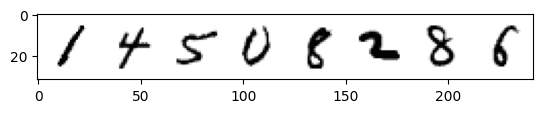

In [5]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
#下载MNIST数据集到mnist文件夹中，设置为训练集
 
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
#使用DataLoader将dataset设置乱序（shuffle），批处理量：8张
 
x, y = next(iter(train_dataloader))#取出第一个批次的X、Y
 
print('Input shape:', x.shape)
print('Labels:', y)
print(torchvision.utils.make_grid(x)[0].shape)
 
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
plt.show()

In [6]:
#根据amount为输入x添加噪声，退化过程
def corrupt(x, amount):
 
  noise = torch.rand_like(x) #根据X的Size生成一张0~1的张量，高斯分布
 
  amount = amount.view(-1, 1, 1, 1) # 整理amount的形状，符合张量要求
 
  return x*(1-amount) + noise*amount

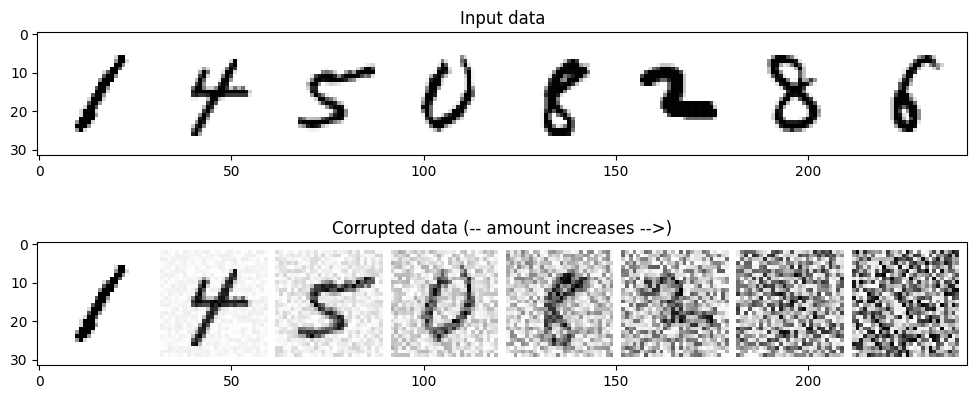

In [7]:
# 绘制输入数据：X为8张MNIST图片
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
 
# 添加噪声
amount = torch.linspace(0, 1, x.shape[0]) # amount包含8个数值，0-1逐步增强。
noised_x = corrupt(x, amount) #8张图片按次序逐步增强噪声
 
# 绘制添加噪声后的图像
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')
plt.show()

In [8]:
class BasicUNet(nn.Module):
  """A minimal UNet implementation."""
 
  def __init__(self, in_channels=1, out_channels=1):
    super().__init__()
    self.down_layers = torch.nn.ModuleList([
      nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
      nn.Conv2d(32, 64, kernel_size=5, padding=2),
      nn.Conv2d(64, 64, kernel_size=5, padding=2),
    ])
    self.up_layers = torch.nn.ModuleList([
      nn.Conv2d(64, 64, kernel_size=5, padding=2),
      nn.Conv2d(64, 32, kernel_size=5, padding=2),
      nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
    ])
    self.act = nn.SiLU()  # The activation function
    self.downscale = nn.MaxPool2d(2)
    self.upscale = nn.Upsample(scale_factor=2)
 
  def forward(self, x):
    h = []
    for i, l in enumerate(self.down_layers):
      x = self.act(l(x))  # 通过运算层和激活函数
      if i < 2:  # 除了第3层（最后一层）以外的层
        h.append(x)  # 排列残差连接使用的数据
        x = self.downscale(x)  # 下采样：最大池化，匹配下一层的输入
 
    for i, l in enumerate(self.up_layers):
      if i > 0:  # 选择除了第1个上采样层以外的层
        x = self.upscale(x)  # Upscale上采样
        x += h.pop()  # 得到之前排列好的供残差连接使用的数据
      x = self.act(l(x))  # 通过运算层和激活函数
 
    return x

Finished epoch 0. Average loss for this epoch: 0.026723
Finished epoch 1. Average loss for this epoch: 0.020552
Finished epoch 2. Average loss for this epoch: 0.018785
Finished epoch 3. Average loss for this epoch: 0.017853
Finished epoch 4. Average loss for this epoch: 0.017237
Finished epoch 5. Average loss for this epoch: 0.016702
Finished epoch 6. Average loss for this epoch: 0.016585
Finished epoch 7. Average loss for this epoch: 0.016094
Finished epoch 8. Average loss for this epoch: 0.016089
Finished epoch 9. Average loss for this epoch: 0.015999


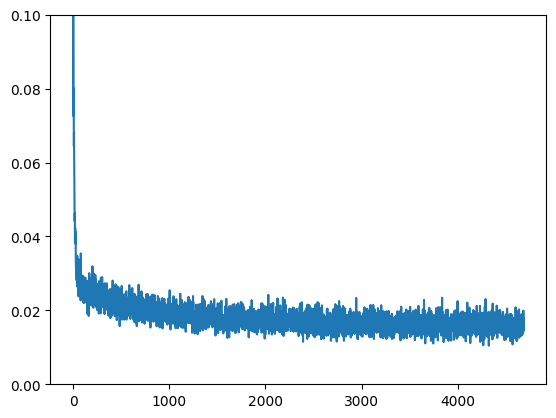

In [9]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
 
# How many runs through the data should we do?
n_epochs = 10
 
# Create the network
net = BasicUNet()
net.to(device)
 
# Our loss finction
loss_fn = nn.MSELoss()  #损失函数：均方误差损失
 
# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) #制定优化器：Adam优化器；更新参数的算法称为优化器
 
# Keeping a record of the losses for later viewing
losses = [] #损失值记录
 
# The training loop
for epoch in range(n_epochs):
 
    for x, y in train_dataloader:
 
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x
 
        # Get the model prediction：得到预测值
        pred = net(noisy_x)
 
        # Calculate the loss：计算损失并比较
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?
 
        # Backprop and update the params:更新参数：反向传播
        opt.zero_grad()
        loss.backward()
        opt.step()
 
        # Store the loss for later：记录损失值
        losses.append(loss.item())
 
    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')
 
# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);
plt.show()

In [11]:
print(net)

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): SiLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)


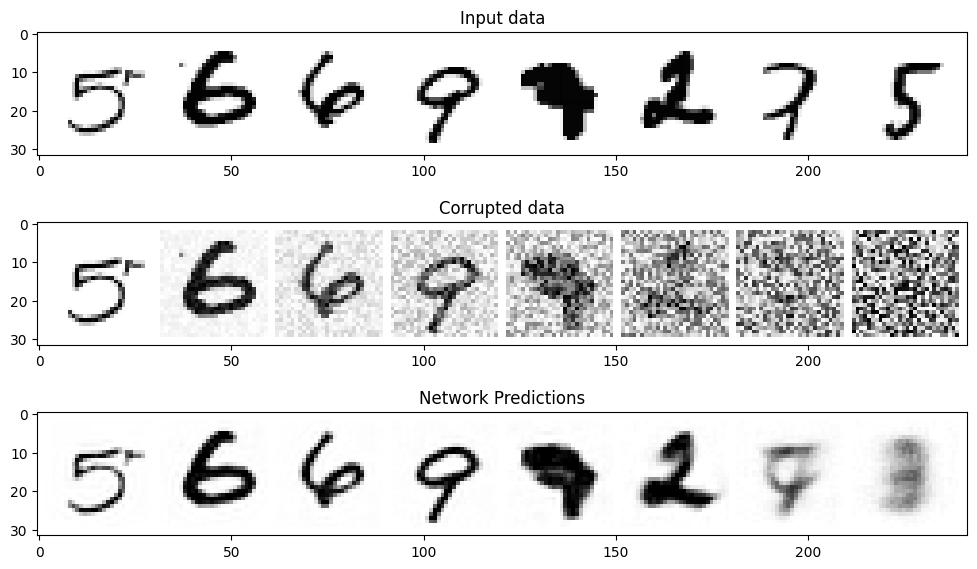

In [10]:
#### 带噪数据预测 ############
#取出数据集中8条数据
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting
 
 
#对8条数据随机添加噪声：（0-1）之间增加退化量
# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)
 
# Get the model predictions
with torch.no_grad(): #禁用梯度计算：训练好的模型使用禁用梯度计算提高速度
  preds = net(noised_x.to(device)).detach().cpu() #阻断反向传播的，经过detach()方法后，变量仍然在GPU上，再利用.cpu()将数据移至CPU中进行后续操作
 
# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');
plt.show()